## Выделить независимые и зависимые переменные
#### Независимые:
- Timing - когда проходило тестирование

#### Зависимые:

- Понимание речи: коэффициент афазии - суммарный коэффициент афазии по результатам группы тестов на понимание речи, принимает значения от 0 до 3, где 3 - нет нарушений речи, 0 - грубые нарушения речи
- Порождение речи: коэффициент афазии - суммарный коэффициент афазии по результатам группы тестов на порождение речи, принимает значения от 0 до 3, где 3 - нет нарушений речи, 0 - грубые нарушения речи 

#### Побочные (ковариаты):

- ID - идентификатор пациента
- AGE - возраст пациента
- Localisation – локализация
- Dominant_hand – ведущая рука
- Diagnosis – диагноз

In [90]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

import scipy
from scipy import stats
from scipy.stats import kruskal, chi2, f_oneway

import matplotlib.pyplot as plt
import seaborn as sns

import pathlib

In [91]:
DATADIR = pathlib.Path.cwd() / "data"
RANDOM_STATE = 42

In [92]:
df_data = pd.read_excel(DATADIR / "DATA_RAT.xlsx")
df_data.head()

,gender,dominant_hand,localisation,diagnosis,ID,Age,Timing,Понимание речи: коэффициент афазии,Порождение речи: коэффициент афазии
0,ж,правша,лоб,опухль,44,37.0,катамнез,3.000000,3.0
1,ж,правша,лоб,опухль,44,35.0,до,3.000000,3.0
2,ж,правша,лоб,опухль,44,35.0,после,2.600000,3.0
3,ж,правша,лоб,опухль,45,47.0,до,2.833333,3.0
4,ж,правша,лоб,опухль,45,47.0,после,3.000000,3.0


In [93]:
df_data = df_data.drop(
    ["gender", "dominant_hand", "localisation", "diagnosis", "ID", "Age", "Порождение речи: коэффициент афазии"],
    axis=1
)

In [94]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1331 entries, 0 to 1330
Data columns (total 2 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Timing                              1331 non-null   object 
 1   Понимание речи: коэффициент афазии  1303 non-null   float64
dtypes: float64(1), object(1)
memory usage: 20.9+ KB


In [95]:
df_data = df_data.dropna(subset=['Понимание речи: коэффициент афазии'])

In [96]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1303 entries, 0 to 1330
Data columns (total 2 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Timing                              1303 non-null   object 
 1   Понимание речи: коэффициент афазии  1303 non-null   float64
dtypes: float64(1), object(1)
memory usage: 30.5+ KB


In [97]:
df_data["Timing"].unique()

array(['катамнез', 'до', 'после', 'После', 'после '], dtype=object)

In [98]:
df_data["Timing"] = df_data["Timing"].map(lambda elem: elem.strip().lower())

In [99]:
df_data["Timing"].unique()

array(['катамнез', 'до', 'после'], dtype=object)

## Гипотезы

- H0: Понимание речи: коэффициент афазии в период после операции не изменился по сравнению с периодом до операции.
- H1: Понимание речи: коэффициент афазии в период после операции изменился по сравнению с периодом до операции.

## Парность выборок

Да, выборки парные. Измерения коэффициента афазии до и после операции проводятся на одних и тех же пациентах.

In [100]:
groups = df_data.groupby(['Timing'])
groups.groups.keys()

dict_keys(['до', 'катамнез', 'после'])

In [101]:
group_do = groups.get_group(("до",))
group_do.head(5)

,Timing,Понимание речи: коэффициент афазии
1,до,3.000000
3,до,2.833333
5,до,2.833333
7,до,2.833333
10,до,2.833333


In [102]:
group_posle = groups.get_group(("после",))
group_posle.head(5)

,Timing,Понимание речи: коэффициент афазии
2,после,2.600000
4,после,3.000000
6,после,1.833333
8,после,3.000000
11,после,3.000000


In [103]:
group_do.describe()

,Понимание речи: коэффициент афазии
count,604.000000
mean,2.625662
std,0.415976
min,0.000000
25%,2.500000
50%,2.666667
75%,2.833333
max,3.000000


In [104]:
group_posle.describe()

,Понимание речи: коэффициент афазии
count,567.000000
mean,2.443886
std,0.524254
min,0.000000
25%,2.166667
50%,2.666667
75%,2.833333
max,3.000000


<Axes: xlabel='Понимание речи: коэффициент афазии', ylabel='Count'>

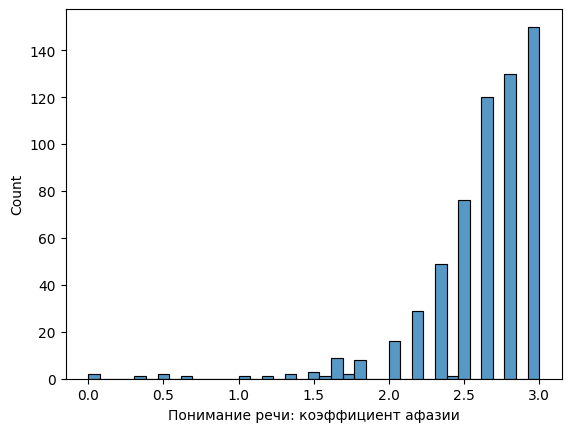

In [105]:
sns.histplot(group_do["Понимание речи: коэффициент афазии"])

<Axes: xlabel='Понимание речи: коэффициент афазии', ylabel='Count'>

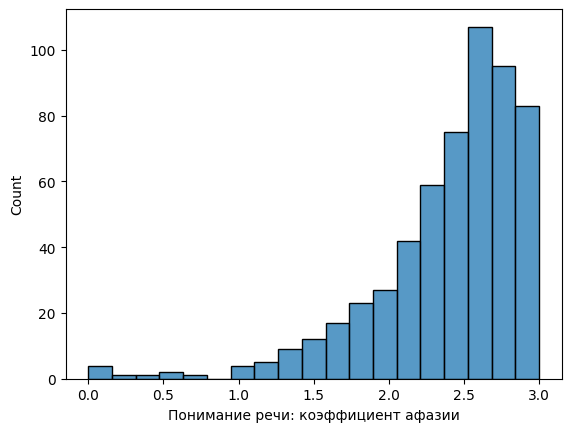

In [106]:
sns.histplot(group_posle["Понимание речи: коэффициент афазии"])

t test

In [107]:
stats.shapiro(group_posle['Понимание речи: коэффициент афазии'])

ShapiroResult(statistic=np.float64(0.8459661299555452), pvalue=np.float64(4.741756591985417e-23))

In [108]:
stats.shapiro(group_do['Понимание речи: коэффициент афазии'])

ShapiroResult(statistic=np.float64(0.7745534502101346), pvalue=np.float64(5.358578988203069e-28))

In [109]:
## Данные распределены ненормально

In [110]:
u, p_val = stats.mannwhitneyu(
    group_posle['Понимание речи: коэффициент афазии'],
    group_do['Понимание речи: коэффициент афазии']
)

In [111]:
u, p_val

(np.float64(132395.0), np.float64(1.0478461816679817e-11))

In [112]:
t, p_val = stats.ttest_ind(
    group_posle['Понимание речи: коэффициент афазии'],
    group_do['Понимание речи: коэффициент афазии']
)

In [113]:
u, p_val

(np.float64(132395.0), np.float64(6.517465140271964e-11))

In [114]:
## p_val СИЛЬНО меньше порога 0.05, эффект сильно значим. t < 0, т е в группе ПОСЛЕ значение МЕНЬШЕ чем в группе ДО